<a href="https://colab.research.google.com/github/osherlock1/AI-Image-Detection-Model/blob/main/exoplanet_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exoplanet Detection CNN Modle

**Project Overview:**
This notebook implemetns a complete pipeline for automatic exoplanet transit destection in stellar light curve data from the Kepler-2 Misison.  The light curves are classified using a lightweight 1D CNN.



## Setup

In [120]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import random
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

**Connect to Google Drive**

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Config

In [122]:
CONFIRMED_DATA_DIR   = '/content/drive/MyDrive/ELE391_Final_Project/data_v4/K2_conf_pt'
FALSE_POS_DIR = '/content/drive/MyDrive/ELE391_Final_Project/data_v4/K2_fp_pt'
BATCH_SIZE = 64
LR         = 1e-3
EPOCHS     = 20
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

## Load Processed Lightcurve Data

In [123]:
#Path to processed data saved in my drive
confirmed_planets_dir = CONFIRMED_DATA_DIR
false_positives_dir = FALSE_POS_DIR

# Helper function to load tensors and add labels
def load_and_label_tensors(directory, label):
    tensors = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.pt'):
            filepath = os.path.join(directory, filename)
            lightcurve = torch.load(filepath)
            tensors.append(lightcurve)  # Add batch dimension
            labels.append(label)  # Assign the label
    return tensors, labels

# Load confirmed planets (label 1)
confirmed_tensors, confirmed_labels = load_and_label_tensors(confirmed_planets_dir, label=1)

# Load false positives (label 0)
false_tensors, false_labels = load_and_label_tensors(false_positives_dir, label=0)

# Combine the tensors and labels
all_tensors = confirmed_tensors + false_tensors
all_labels = confirmed_labels + false_labels

In [113]:
# Stack all light curves into a single tensor (num_samples, 200)
data = torch.stack(all_tensors)

# Convert labels to a tensor (num_samples,)
labels = torch.tensor(all_labels, dtype=torch.long)

print("Data Shape:", data.shape)
print("Labels Shape:", labels.shape)

Data Shape: torch.Size([1002, 400])
Labels Shape: torch.Size([1002])


**Data Augmentatino with SMOTE**

In [114]:
smote = SMOTE(random_state=42)  # You can set a random state for reproducibility
balanced_data_np, balanced_labels_np = smote.fit_resample(data.cpu().numpy(), labels.cpu().numpy())

# Convert back to PyTorch tensors
data = torch.tensor(balanced_data_np, dtype=data.dtype, device=data.device)
labels = torch.tensor(balanced_labels_np, dtype=labels.dtype, device=labels.device)
data = data.unsqueeze(1)

**Normalize Dataset**

In [115]:
# Normalize each sample in the dataset
data_mean = data.mean(dim=-1, keepdim=True)  # Mean across the sequence
data_std = data.std(dim=-1, keepdim=True)    # Standard deviation across the sequence
data = (data - data_mean) / data_std

dataset = TensorDataset(data, labels)

**Split the Dataset**

In [116]:
dataset_size = len(dataset)
train_size = int(0.8* dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

**Create DataLoaders**

In [117]:

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False, drop_last = True)

## CNN Model

In [119]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super(ConvolutionalNetwork, self).__init__()
    #Describe convolutional layer and what it's doing (2 convolutional layers)
    self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 4, stride = 2, padding = 1)
    self.conv2 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 8, stride = 2, padding = 1)
    self.conv3 = nn.Conv1d(in_channels = 32, out_channels =  64, kernel_size = 12, stride = 2, padding = 1)
    self.conv4 = nn.Conv1d(in_channels = 64, out_channels = 16, kernel_size = 20, stride = 2, padding = 1)
    self.conv5 = nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size = 4, stride = 2, padding = 1)

    dummy_input = torch.randn(1, 1, 400)
    x = F.relu(self.conv1(dummy_input))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    flattened_size = x.view(x.size(0), -1).size(1)


    self.fc1 = nn.Linear(flattened_size, 128)
    self.fc2 = nn.Linear(128,128)
    self.fc3 = nn.Linear(128,2)

  def forward(self, x):
    X = F.relu(self.conv1(x))
    X = F.relu(self.conv2(X))
    X = F.relu(self.conv3(X))
    X = F.relu(self.conv4(X))
    X = F.relu(self.conv5(X))


    X = X.view(X.size(0), -1)

    #Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim = 1)

model = ConvolutionalNetwork().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Training Loop

In [ ]:

train_losses = []
val_losses = []
train_correct= []
val_correct =[]

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


for i in range(EPOCHS):
  trn_corr = 0
  val_corr = 0

  for data, labels in train_loader:

    y_pred = model(data)
    loss = criterion(y_pred, labels)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == labels).sum()
    trn_corr += batch_corr # keep track as we go along

    #Update our paremeters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():
    for data, labels in val_loader:
      y_val = model(data)
      predicted = torch.max(y_val.data, 1)[1]
      val_corr += (predicted == labels).sum()

    val_loss = criterion(y_val, labels)
  val_losses.append(val_loss.item())
  val_correct.append(val_corr.item())
  scheduler.step()
  train_acc = trn_corr.item() / len(train_loader.dataset) * 100
  val_acc = val_corr.item() / len(val_loader.dataset) * 100

  print(f"Epoch {i+1}/{EPOCHS}")
  print(f"Train Loss: {loss.item():.4f} | Train Accuracy: {train_acc:.2f}%")
  print(f"Val Loss: {val_loss.item():.4f} | Val Accuracy: {val_acc:.2f}%")

Epoch 1/20
Train Loss: 0.6369 | Train Accuracy: 58.91%
Val Loss: 0.5892 | Val Accuracy: 63.75%
Epoch 2/20
Train Loss: 0.5160 | Train Accuracy: 76.64%
Val Loss: 0.5620 | Val Accuracy: 79.38%
Epoch 3/20
Train Loss: 0.1584 | Train Accuracy: 85.78%
Val Loss: 0.2736 | Val Accuracy: 85.00%
Epoch 4/20
Train Loss: 0.5166 | Train Accuracy: 92.27%
Val Loss: 0.1569 | Val Accuracy: 86.25%
Epoch 5/20
Train Loss: 0.0343 | Train Accuracy: 97.03%
Val Loss: 0.0551 | Val Accuracy: 93.12%
Epoch 6/20
Train Loss: 0.0581 | Train Accuracy: 97.11%
Val Loss: 0.2223 | Val Accuracy: 90.62%
Epoch 7/20
Train Loss: 0.0763 | Train Accuracy: 98.05%
Val Loss: 0.7153 | Val Accuracy: 88.75%
Epoch 8/20
Train Loss: 0.0058 | Train Accuracy: 98.36%
Val Loss: 0.0149 | Val Accuracy: 93.12%
Epoch 9/20
Train Loss: 0.0092 | Train Accuracy: 99.53%
Val Loss: 0.1039 | Val Accuracy: 93.75%
Epoch 10/20
Train Loss: 0.0002 | Train Accuracy: 99.84%
Val Loss: 0.0668 | Val Accuracy: 93.75%
Epoch 11/20
Train Loss: 0.0004 | Train Accuracy: 

## Evaluate

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the model on the test set
test_corr = 0
test_loss = 0
all_labels = []
all_predictions = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():  # Disable gradient computation
    for data, labels in test_loader:
        y_test = model(data)  # Forward pass
        test_loss += criterion(y_test, labels).item()  # Accumulate test loss
        predicted = torch.max(y_test.data, 1)[1]  # Get predictions
        test_corr += (predicted == labels).sum()  # Count correct predictions

        # Store predictions and labels for metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy and average loss
test_acc = test_corr.item() / len(test_loader.dataset) * 100
test_loss /= len(test_loader)

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1-Score: {f1:.2f}")

Test Loss: 0.2258 | Test Accuracy: 97.50%
Precision: 0.97 | Recall: 0.97 | F1-Score: 0.97


Classification Report:
              precision    recall  f1-score   support

  No Transit       0.99      0.87      0.92        76
     Transit       0.89      0.99      0.94        84

    accuracy                           0.93       160
   macro avg       0.94      0.93      0.93       160
weighted avg       0.94      0.93      0.93       160



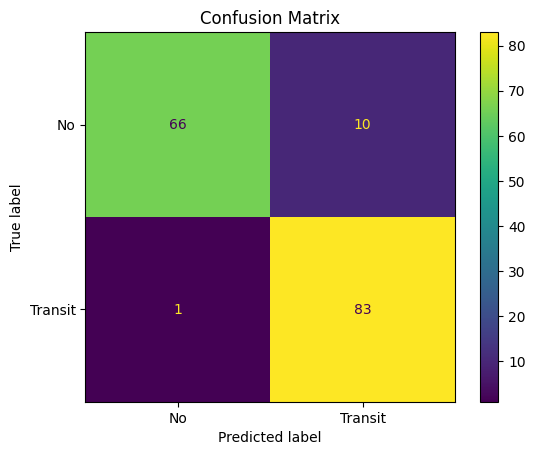

In [ ]:

model.to(DEVICE)
model.eval()


y_true, y_pred, y_proba = [], [], []
with torch.no_grad():
    for x, y in val_loader:                         # or test_loader
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        probs = F.softmax(logits, dim=1)[:, 1]       # P(transit)
        preds = logits.argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs.cpu().numpy())

#Classification report
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["No Transit", "Transit"],
))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No", "Transit"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()




